# Matrix Element / Optimal Observable method

In [1]:
# third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.stats import poisson

# custom modules
from hstar import c6
from inference import stat

In [2]:
importlib.reload(c6)

# total luminosity (fb^-1)
lumi = 300.0

# read events of each sample
filepath = 'data/samples/ggZZ_all/events.csv'
events = pd.read_csv(filepath,nrows=1000000)
ggzz = c6.Sample(k=1.83, xs=1.4783394 * 4, events=events) # cross-section x k-factor x 4l channels (ignoring interference for now) [fb]
ggzz.normalize(lumi)
ggzz.events.head()

,evtnum,p1_px,p1_py,p1_pz,p1_E,p2_px,p2_py,p2_pz,p2_E,p3_px,...,msq_c6_14,msq_c6_15,msq_c6_16,msq_c6_17,msq_c6_18,msq_c6_19,msq_c6_20,msq_c6_21,msq_sm,wt
0,0,0.0,0.0,-253.25920,-253.25920,0.0,0.0,43.80087,-43.80087,3.418067,...,1.311460e-08,1.311711e-08,1.312060e-08,1.312512e-08,1.313072e-08,1.313747e-08,1.314548e-08,1.315483e-08,1.311264e-08,0.001402
1,1,0.0,0.0,-105.41780,-105.41780,0.0,0.0,83.06607,-83.06607,-33.927600,...,1.624623e-08,1.624879e-08,1.625244e-08,1.625720e-08,1.626311e-08,1.627022e-08,1.627859e-08,1.628827e-08,1.624494e-08,0.001324
2,2,0.0,0.0,-176.49030,-176.49030,0.0,0.0,69.49255,-69.49255,-23.966820,...,5.646427e-09,5.647883e-09,5.649893e-09,5.652477e-09,5.655658e-09,5.659462e-09,5.663923e-09,5.669079e-09,5.645296e-09,0.001726
3,3,0.0,0.0,-73.21253,-73.21253,0.0,0.0,435.57040,-435.57040,32.089890,...,9.708751e-11,9.714519e-11,9.723117e-11,9.734593e-11,9.749014e-11,9.766467e-11,9.787056e-11,9.810907e-11,9.708228e-11,0.009405
4,4,0.0,0.0,-395.79670,-395.79670,0.0,0.0,24.94625,-24.94625,-50.250540,...,7.705212e-09,7.707123e-09,7.709840e-09,7.713385e-09,7.717782e-09,7.723063e-09,7.729268e-09,7.736440e-09,7.704206e-09,0.006188


## $ OO_{c_6} = p(c_6) / p_{\mathrm{SM}} $

The idea of a parametrized optimal observable is to take the density ratio

$$ OO_{c_6} = p(x_i | c_6) / p_{\mathrm{SM}}(x_i), $$

which should be the definition of a summary statistic that is has the most statistical power to distinguish between the two hypotheses at the given $c_6$ value.
This observable is binned into a histogram for multiple datasets, each generated under a range of $c_6$-hypotheses, as follows:

- The computation of the probability ratio for each event in the dataset under a given $c_6$-hypothesis follows [`sensitivity-unbinnned.ipynb`](sensitivity-mem.ipynb). 
- The weight of the event is also morphed to the corresponding $c_6$-hypothesis when being filled into the histogram.

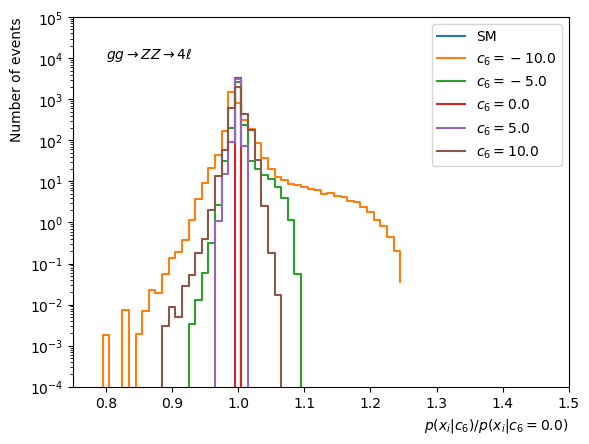

In [3]:
c6_min = -10.
c6_max = 10.
c6_step = 5.
c6_vals = np.arange(c6_min, c6_max+c6_step, c6_step)

pratio_bins = np.linspace(0.745, 1.505, num=77)

def plothist(entries, *, bins=None, weights=None, label=''):
  hist, bin_edges = np.histogram(entries, bins=bins, 
                               weights=weights)
  plt.step(bin_edges[:-1], hist, where='post', label=label)
  return hist, bin_edges

p_sm = ggzz.nu(per_event=True) / ggzz.nu()
oo_sm, _ = plothist(p_sm / p_sm, bins=pratio_bins, 
                               weights=ggzz.nu(per_event=True), label='SM')

oo_c6 = []
p_c6 = ggzz.nu(c6_vals,per_event=True)/ggzz.nu(c6_vals)
for i, c6_val in enumerate(c6_vals):
  oo_vals, _ = plothist(p_c6[:, i] / p_sm, bins=pratio_bins, 
          weights=ggzz.nu(c6_val,per_event=True), label=f'$c_6 = {c6_val}$')

  oo_c6.append(oo_vals)

plt.legend()

ax = plt.gca()

ax.set_xlim([0.75, 1.5])
ax.set_ylim([1e-4, 1e5])
ax.set_yscale('log')
ax.set_xlabel('$p(x_i | c_6) / p(x_i | c_6 = 0.0)$', loc='right')
ax.set_ylabel('Number of events', loc='top')

plt.text(0.80, 1e4, '$gg \\to ZZ \\to 4 \\ell$')
plt.show()

It can be observed that for the SM:

- The parametrized-OO predicts a dirac-$\delta$ distribution, since $p_{\mathrm{SM}}(x_i) / p_{\mathrm{SM}}(x_i) = 1$ for all $x_i$.

Whereas for other $c_6$ hypotheses, two changes can occur: 

- The relative probability of a given event $x_i$ relative to other events can be de/enhanced compared to that of the SM depending on different polynomial dependence, $a_{\{1,2,3,4\},i}$, for the $i$-th event, which will result in $OO_{c_6} \neq 1$.
- The absolute weight of the event ${x_i}$ can be de/enhanced compared to the SM, predicting total number of events different from that of the SM.

## Sensitivity study using $OO_{c_6}$

Now suppose that the experimenter observes a dataset corresponding to SM, $\mathcal{D}_{\mathrm{obs}}$, and must infer which value of $c_6$ is the most likely (which should of course be $0$). The maximum likelihood proceeds as the following:

- (In this toy study, the observed SM dataset shall remain identical to the baseline simulated dataset)
- For each value of $c_6$ being considered:
  - The (morphed) dataset corresponding $c_6$-hypothesis, i.e. from $\mathcal{D}(c_6)$, and thus its $OO_{c_6}$ distribution, is already known.
  - For each event $x_i$ in $\mathcal{D}_{\mathrm{obs}}$, the density ratio is computed; by virtue of the first point, this will yield exactly the same values as that of $\mathcal{D}(c_6)$.
  - The event weight of $x_i$ in $\mathcal{D}_{\mathrm{obs}}$, however, is that of the SM.

Then, one can evaluate the likelihood of the observed dataset given the expected $c_6$-hypothesis, $\mathcal{L} ( \mathcal{D}_{\mathrm{obs}} | c_6 )$.

### Example: $c_6 = 0$ (SM)

The above procedure will, by construction, yield distributions whose entries are identical between the observed and simulated datasets, except they are filled with differing event weights. The only scenario in which the latter is the same and thus yield identical distributions, is under the SM diract-$\delta$ scenario.

[   0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
 3246.4333224    0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.       ] [   0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
 3246.4333224    0.           0.           0.           0.
    0.           0.           0.         

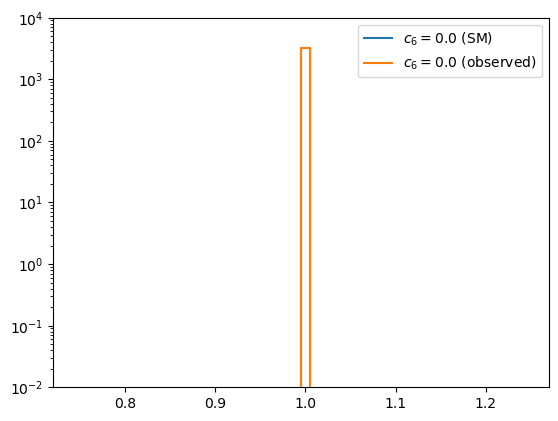

In [4]:
c6_val = 0.0

nu_c6 = np.array(ggzz.nu(c6_val,per_event=True))
nu_sm = np.array(ggzz.nu(per_event=True))
p_c6 = nu_c6 / ggzz.nu(c6_val)
p_sm = nu_sm / ggzz.nu()

oo_exp, _ = np.histogram(p_c6 / p_sm, bins=pratio_bins, 
        weights=nu_c6)
oo_obs, _ = np.histogram(p_sm / p_sm, bins=pratio_bins, 
        weights=nu_sm)

plt.step(pratio_bins[:-1], oo_exp, where='post', label='$c_6 = 0.0$ (SM)')
plt.step(pratio_bins[:-1], oo_obs, where='post', label='$c_6 = 0.0$ (observed)')

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim(1e-2,1e4)

print(oo_obs, oo_exp)
nll = stat.nll(oo_obs, oo_exp)
print('NLL = ', nll)
print('-log(Pois(3200|3200)) = ', -np.log(poisson.pmf(3200,3200)))

plt.show()

Intuitively, this should always give the best likelihood, i.e. lowest $-\log{\mathcal{L}}$, since the observed and expected distributions are exactly the same.
The obtained value can be straightforwardly understood as simply the value of $\mathcal{L} = \mathrm{Pois}( N_{\mathrm{obs}} | \nu_{\mathrm{SM}})$, where $N_{\mathrm{obs}} = \nu_{\mathrm{SM}} \approx 3200$.

### Example: $c_6 = -10$

Under a $c_6$-hypothesis that is different from that of the observed dataset however, the event weights will be different.

NLL =  69.47505391307926


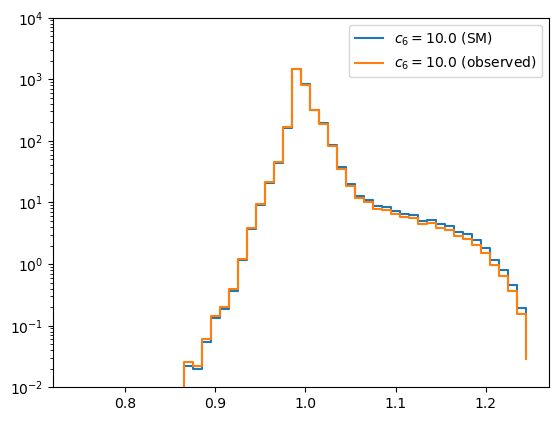

In [5]:
c6_val = -10.0

nu_c6 = np.array(ggzz.nu(c6_val,per_event=True))
nu_sm = np.array(ggzz.nu(per_event=True))
p_c6 = nu_c6 / ggzz.nu(c6_val)
p_sm = nu_sm / ggzz.nu()

oo_exp, _ = np.histogram(p_c6 / p_sm, bins=pratio_bins, 
        weights=nu_c6)
oo_obs, _ = np.histogram(p_c6 / p_sm, bins=pratio_bins, 
        weights=nu_sm)

plt.step(pratio_bins[:-1], oo_exp, where='post', label='$c_6 = 10.0$ (SM)')
plt.step(pratio_bins[:-1], oo_obs, where='post', label='$c_6 = 10.0$ (observed)')

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_ylim(1e-2,1e4)

nll = stat.nll(oo_obs, oo_exp)
print('NLL = ', nll)

plt.show()

Clearly, the compatibility between the observed and SM distributions are worse due to the different event weights.

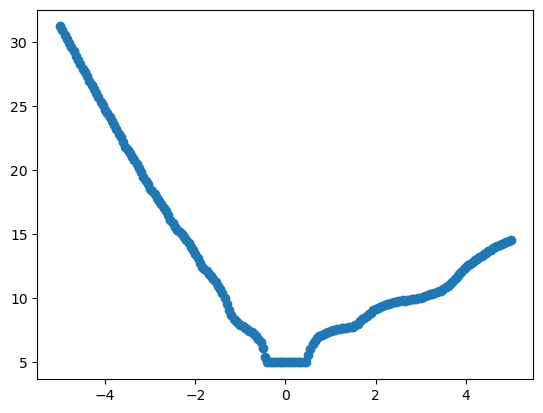

In [6]:
c6_min = -5.0
c6_max = 5.0
c6_nvals = 200
c6_vals = np.linspace(c6_min, c6_max, c6_nvals+1)
nll = np.ones_like(c6_vals)

nu_c6 = np.array(ggzz.nu(c6_vals,per_event=True))
nu_sm = np.array(ggzz.nu(per_event=True))
p_c6 = nu_c6 / ggzz.nu(c6_vals)
p_sm = nu_sm / ggzz.nu()

for i, c6_val in enumerate(c6_vals):
  oo_obs, _ = np.histogram(p_c6[:,i] / p_sm, bins=pratio_bins, 
                                weights=nu_sm)
  oo_exp, _ = np.histogram(p_c6[:,i] / p_sm, bins=pratio_bins, 
                                weights=nu_c6[:, i])
  nll[i] = stat.nll(oo_obs, oo_exp)

imin = np.argmin(nll)
nll_min = nll[imin]
c6_at_nll_min = c6_vals[imin]

plt.scatter(c6_vals, nll)
plt.show()

Now this seems quite strange:

- The NLL value is pretty much flat in the vicinity of $0$.
  - Reasonable as $c_6$ will not induce appreciable modification to the SM spectra.
- Around $c_6 \sim 0.5$, there is a sharp kink+rise in the NLL.
- This is followed by discontinuities further out around $c_6 \sim -2, -3, \dots$.

This is actually easily explained by the fact that as $|c_6|$ increases, events start to migrate out to $OO_{c_6} \neq 1$ bins. And NLL of histograms with a different number of non-zero bins will be different from that of one, even if the observed and expected event yields sum up to the same total! i.e.

$$-\log(\mathrm{Pois}(3200 | 3200)) = 4.954$$
$$-\log(\mathrm{Pois}(1600|1600) \mathrm{Pois(1600|1600)}) = 9.215$$

(This specific discontinuity is being masked in the current binning, which centers around $c_6 = 0.0$ rather than at it.)

Is this NLL curve sensible? Or is there (probably) something wrong in the methodology of implementing the MEM inference?

In [7]:
print(-np.log(poisson.pmf(3200,3200)))
print(-np.log(poisson.pmf(1600,1600) * poisson.pmf(1600,1600)))

4.954417619261221
9.215740141302376
